# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# EDA: Exploratory Data Analysis

## All songs

In [14]:
# Read the data
df = pd.read_csv('/home/pabloperez/Desktop/MasterBD/AnalisisNoEstructurados/TEXT/archive/lyrics-data.csv')


In [15]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df['Number_of_words'].describe()

count    379931.000000
mean        206.336335
std         146.607896
min           0.000000
25%         112.000000
50%         169.000000
75%         254.000000
max        5505.000000
Name: Number_of_words, dtype: float64

/tmp/ipykernel_39689/1092970249.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

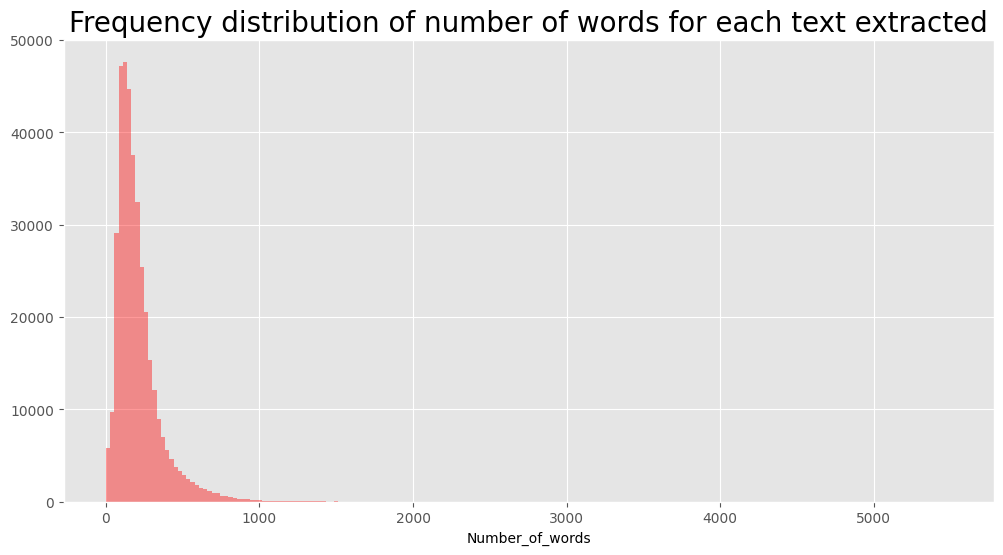

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

## Filtered songs

In [17]:
# select only Snoop Doggs english songs
df = df[(df['ALink'] == '/snoop-dogg/') & (df['language'] == 'en')]

In [18]:
df['Number_of_words'] = df['Lyric'].apply(lambda x:len(str(x).split()))
df['Number_of_words'].describe()

count     485.000000
mean      539.665979
std       185.268087
min        40.000000
25%       423.000000
50%       531.000000
75%       672.000000
max      1210.000000
Name: Number_of_words, dtype: float64

/tmp/ipykernel_39689/1092970249.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

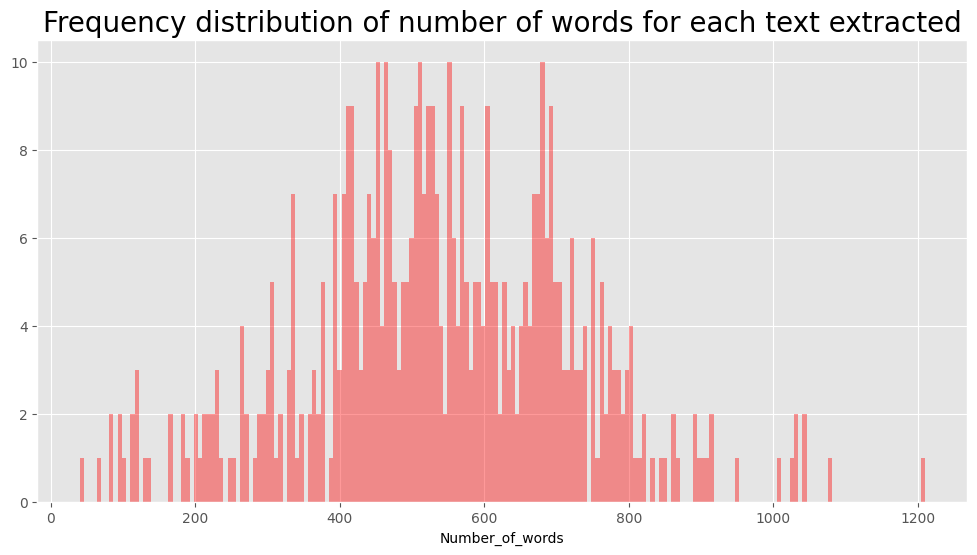

In [19]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [ ]:
# drop the columns that are not required
df.drop(['ALink','SName','SLink', 'Number_of_words'],axis=1,inplace=True)
# select the sample
df = df[:100]
df.shape

# Data Preprocessing

In [3]:
# Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation. 
tokenizer = Tokenizer()

# apply the tokenizer on the lyrics column
tokenizer.fit_on_texts(df['Lyric'].astype(str).str.lower())

# adding 1 because of reserved 0 index
total_words = len(tokenizer.word_index)+1


tokenized_sentences = tokenizer.texts_to_sequences(df['Lyric'].astype(str))
# Turns the words into integer type by classifying them according to word dictionary.
tokenized_sentences[0]

In [4]:
input_sequences = list()

for i in tokenized_sentences:
    for t in range(1, len(i)):
        # Create an n-gram sequence from the beginning to the current index
        n_gram_sequence = i[:t+1]
        # Append the n-gram sequence to the input sequences list
        input_sequences.append(n_gram_sequence)

# Get the maximum length of all input sequences
max_sequence_len = max([len(x) for x in input_sequences])

# Convert the list of input sequences into a numpy array
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


# Train Test Split

In [5]:
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
# Takes all elemnts in each row, except the last element, and places them in X ,while labels takes the last element (the element which we should predict)

y = tf.keras.utils.to_categorical(labels, num_classes=total_words) # One hot encoding

# Model Building

We used LSTM instead of simple RNN as simple RNN faces a vanishing gradient.We need to remember the previous words, to predict the next words:

* LSTM(250): Creates an LSTM layer with 250 memory units (also known as LSTM cells). The LSTM layer is a type of recurrent layer that can capture sequential patterns in the data.

* Bidirectional: Wraps the LSTM layer with a bidirectional layer. The bidirectional layer processes the input sequence in two directions: from left to right and from right to left. This allows the LSTM layer to capture both the preceding and succeeding context of each time step in the sequence, which can improve the model's ability to understand and model more complex relationships in sequential data.

In [7]:
model = Sequential()
model.add(Embedding(total_words, 40, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

In this model summary::

* Embedding: An embedding layer with an output shape of (None, 1062, 40). It has 217,520 trainable parameters.
bidirectional: A bidirectional layer with an output shape of (None, 500). It has 582,000 trainable parameters.

* Dropout: A dropout layer that randomly sets a fraction of input units to 0 during training, with an output shape of (None, 500). It has no trainable parameters.

* Dense: A fully connected layer with an output shape of (None, 5,438). It has 2,724,438 trainable parameters.

The total number of parameters in the model is 3,523,958, and all of them are trainable.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1062, 40)          217520    
                                                                 
 bidirectional (Bidirectiona  (None, 500)              582000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 5438)              2724438   
                                                                 
Total params: 3,523,958
Trainable params: 3,523,958
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, batch_size=32, epochs=30,callbacks=[earlystop], validation_split = 0.3)

Epoch 1/30


2023-05-16 18:33:03.694122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   1/1224 [..............................] - ETA: 49:59 - loss: 8.6011 - accuracy: 0.0000e+00

2023-05-16 18:33:04.166491: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1224/1224 [==============================] - 98s 78ms/step - loss: 6.5564 - accuracy: 0.0437 - val_loss: 6.7066 - val_accuracy: 0.0449
Epoch 2/30
1224/1224 [==============================] - 98s 80ms/step - loss: 5.8310 - accuracy: 0.0832 - val_loss: 6.6324 - val_accuracy: 0.0593
Epoch 3/30
1224/1224 [==============================] - 102s 84ms/step - loss: 5.2402 - accuracy: 0.1375 - val_loss: 6.6775 - val_accuracy: 0.0709
Epoch 4/30
1224/1224 [==============================] - 99s 81ms/step - loss: 4.6962 - accuracy: 0.1903 - val_loss: 6.8578 - val_accuracy: 0.0721
Epoch 5/30
1224/1224 [==============================] - 95s 78ms/step - loss: 4.1712 - accuracy: 0.2411 - val_loss: 7.0707 - val_accuracy: 0.0731
Epoch 6/30
1224/1224 [==============================] - 98s 80ms/step - loss: 3.6742 - accuracy: 0.2896 - val_loss: 7.3114 - val_accuracy: 0.0696
Epoch 7/30
1224/1224 [==============================] - 102s 83ms/step - loss: 3.2276 - accuracy: 0.3491 - val_loss: 7.4925 - val_accu

In [10]:
model.save('song_lyrics_generator_Snoop.h5')

# Results

<Axes: >

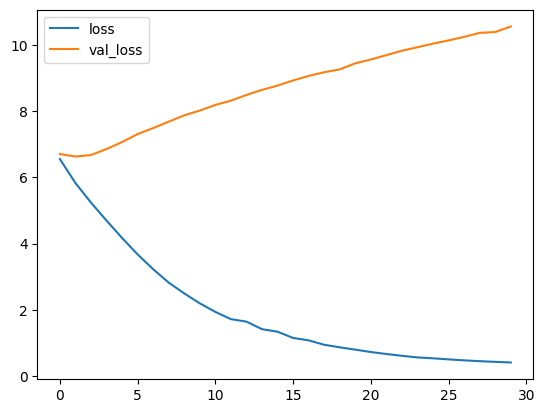

In [11]:
df = pd.DataFrame(history.history)
df[['loss','val_loss']].plot()

In [12]:

def complete_this_song(input_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([input_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        input_text += " " + output_word
    return input_text

In [13]:
complete_this_song("Michael Jordan is", 155)

1/1 [==============================] - 0s 35ms/step


"Michael Jordan is rage snoop dogg there girl was your mothafuckin' of their number your way on the way right yeah yeah i was to do this day yeah yeah get me out the dogg i had to get it in the party just girl put it in the air listen and i know what i ain't never got it for the bitch lil jon they did it was a bitch lost now i have up and i was the bitch lost and i was back in the house so she know what i came up i want to get the front up in the pool and i stay in the cool i ain't playin with fools reset repeat unlock and recock the heat and it gets with a bitch thats in the safe flippin' for the tippin' i'm big at the wind i cracked every colored dice i do it still like that what she put the"